**Данные разбиваются 215 на трейн и 50 на тест**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D
from tensorflow.keras.models import Sequential, Model
from keras.layers import LSTM
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, Concatenate,
                                     Average, Maximum, Add, Subtract, Multiply,
                                    GlobalMaxPooling2D, AveragePooling2D, GlobalAveragePooling2D)

In [2]:
np.random.seed(7)

In [3]:
data_path = '../../data/prod_data/prod_data_wo_nan.xlsx'
df = pd.read_excel(data_path, sheet_name='prod')

In [4]:
df.head(3)

,Date,Day,Well,Formation,Lift type,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours
0,1996-05-01,35186,Plat-2,Evlanov-Livenskian,Natural flow,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0
1,1996-06-01,35217,Plat-2,Evlanov-Livenskian,Natural flow,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0
2,1996-07-01,35247,Plat-2,Evlanov-Livenskian,Natural flow,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0


In [5]:
df.shape

(5665, 15)

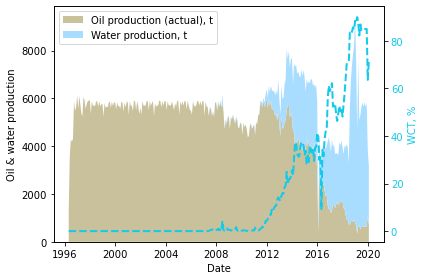

In [6]:
well_name = 'Plat-2'

x = df['Date'].where(df['Well'] == well_name)
y = df['Oil production (actual), t'].where(df['Well'] == well_name).to_numpy(), \
    df['Water production, t'].where(df['Well'] == well_name).to_numpy()
wct = df['WCT'].where(df['Well'] == well_name).to_numpy()

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil & water production', color='black')
colors = ['#C9C19C', '#A9DDFF']
ax1.stackplot(x, y, labels=['Oil production (actual), t', 'Water production, t'], colors=colors)
ax1.tick_params(axis='y', labelcolor='black')


color = '#13CAE9'
ax2.set_ylabel('WCT, %', color=color)  
ax2.plot(x, wct, color=color, linestyle='dashed', linewidth=2,  label='WCT, %')
ax2.tick_params(axis='y', labelcolor=color)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles, labels, loc='upper left')

fig.tight_layout()  
plt.rcParams["figure.figsize"] = (16,6)
plt.show()

In [7]:
len(x)

5665

In [8]:
df.columns

Index(['Date', 'Day', 'Well', 'Formation', 'Lift type', 'Oil production, m3',
       'Oil production (actual), t', 'Water production, m3',
       'Water production, t', 'Gas production, M m3', 'WCT',
       'Oil density, t/m3', 'Water density, t/m3', 'Working hours',
       'Downtime hours'],
      dtype='object')

In [9]:
features = ['Date', 'Day', 'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'Working hours', 'Downtime hours', 'Longitude', 'Latitude']

target = 'WCT'

In [10]:
df['liquid, m3'] = df['Oil production, m3'] + df['Water production, m3']
df.head(3)

,Date,Day,Well,Formation,Lift type,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
0,1996-05-01,35186,Plat-2,Evlanov-Livenskian,Natural flow,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0,1549.516908
1,1996-06-01,35217,Plat-2,Evlanov-Livenskian,Natural flow,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0,4330.917874
2,1996-07-01,35247,Plat-2,Evlanov-Livenskian,Natural flow,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0,5179.951691


In [11]:
#data = df.drop(target, axis=1)
data = df

In [12]:
features, target

(['Date',
  'Day',
  'Oil production, m3',
  'Oil production (actual), t',
  'Water production, m3',
  'Water production, t',
  'Gas production, M m3',
  'Working hours',
  'Downtime hours',
  'Longitude',
  'Latitude'],
 'WCT')

In [13]:
data.columns

Index(['Date', 'Day', 'Well', 'Formation', 'Lift type', 'Oil production, m3',
       'Oil production (actual), t', 'Water production, m3',
       'Water production, t', 'Gas production, M m3', 'WCT',
       'Oil density, t/m3', 'Water density, t/m3', 'Working hours',
       'Downtime hours', 'liquid, m3'],
      dtype='object')

In [14]:
data.drop(['Date', 'Well', 'Formation', 'Lift type'], axis=1, inplace=True)

In [15]:
data.head(3)

,Day,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",WCT,"Oil density, t/m3","Water density, t/m3",Working hours,Downtime hours,"liquid, m3"
0,35186,1549.516908,1283,0.0,0.0,173.20,0.0,0.828,1.164,336.0,408.0,1549.516908
1,35217,4330.917874,3586,0.0,0.0,484.11,0.0,0.828,1.164,696.0,24.0,4330.917874
2,35247,5179.951691,4289,0.0,0.0,630.50,0.0,0.828,1.164,744.0,0.0,5179.951691


In [16]:
features = ['Day', 'Oil production, m3', 'Oil production (actual), t',
       'Water production, m3', 'Water production, t', 'Gas production, M m3',
       'Working hours', 'Downtime hours']


In [17]:
train_size = 215
val_size = 50
bias = 1

train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:train_size + bias + val_size][features]

train_data.shape, val_data.shape

((215, 8), (50, 8))

In [18]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Day,"Oil production, m3","Oil production (actual), t","Water production, m3","Water production, t","Gas production, M m3",Working hours,Downtime hours
0,-1.724247,-8.109071,-8.109071,-0.359144,-0.35914,-8.098885,-11.552428,14.166523
1,-1.707837,-3.662321,-3.662321,-0.359144,-0.35914,-4.115956,-0.894216,0.694768
2,-1.691957,-2.304933,-2.304933,-0.359144,-0.35914,-2.240620,0.526879,-0.147217
3,-1.675547,-2.501880,-2.501880,-0.359144,-0.35914,-2.439184,0.526879,-0.147217
4,-1.659137,-2.258593,-2.258593,-0.359144,-0.35914,-2.054867,-0.183668,-0.147217


Формируем параметры для генерации выборки

In [19]:
x_len = 7

future = 1

learning_rate = 0.001
batch_size = 16
epochs = 200

In [20]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:train_size+val_size + bias][target].values

X_train.shape, y_train.shape, X_val.shape, y_val.shape

8 223
42 224


((215, 8), (215,), (42, 8), (42,))

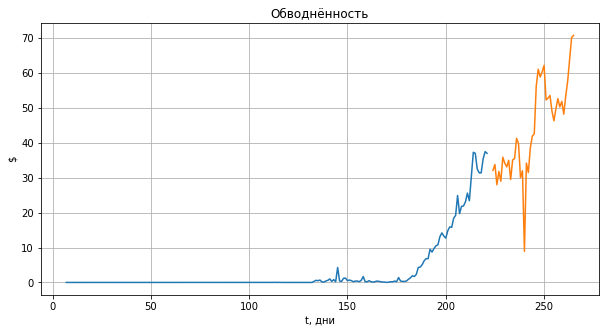

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:train_size+val_size + bias],y_val[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('Обводнённость')
plt.show()

In [22]:
from keras.preprocessing import timeseries_dataset_from_array 

dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [23]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (16, 7, 8)
tf.Tensor(
[[-1.70783748 -3.66232135 -3.66232135 -0.35914405 -0.35913956 -4.11595646
  -0.89421574  0.69476793]
 [-1.69195685 -2.30493313 -2.30493313 -0.35914405 -0.35913956 -2.24062006
   0.52687922 -0.14721679]
 [-1.67554686 -2.50187992 -2.50187992 -0.35914405 -0.35913956 -2.43918358
   0.52687922 -0.14721679]
 [-1.65913688 -2.2585927  -2.2585927  -0.35914405 -0.35913956 -2.05486708
  -0.18366826 -0.14721679]
 [-1.64325625  0.7651199   0.7651199  -0.35914405 -0.35913956  1.20541787
   0.52687922 -0.14721679]
 [-1.62684626 -0.01108219 -0.01108219 -0.35914405 -0.35913956  0.62766207
  -0.18366826 -0.14721679]
 [-1.61096563  0.28240716  0.28240716 -0.35914405 -0.35913956  0.32533309
   0.52687922 -0.14721679]], shape=(7, 8), dtype=float64)
Target shape: (16,)
tf.Tensor(0.0, shape=(), dtype=float64)


In [24]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)


model = Sequential()

model.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model.add(LSTM(32, return_sequences=True))
model.add(Conv1D(64, 3, activation='linear'))
model.add(Conv1D(64, 1, activation='linear'))
model.add(Flatten())
model.add(Dense(3, activation='linear'))
model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 32)             5248      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 32)             8320      
_________________________________________________________________
conv1d (Conv1D)              (None, 5, 64)             6208      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 5, 64)             4160      
_________________________________________________________________
flatten (Flatten)            (None, 320)               0         
_________________________________________________________________
dense (Dense)                (None, 3)                 963       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 4

In [25]:
history = model.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                   )

Epoch 1/200
14/14 [==============================] - 5s 122ms/step - loss: 9.9779 - mae: 0.5919 - val_loss: 1850.7769 - val_mae: 41.3983
Epoch 2/200
14/14 [==============================] - 0s 10ms/step - loss: 9.2134 - mae: 0.6152 - val_loss: 1783.3314 - val_mae: 40.4969
Epoch 3/200
14/14 [==============================] - 0s 10ms/step - loss: 7.9221 - mae: 0.5806 - val_loss: 1647.1599 - val_mae: 38.5841
Epoch 4/200
14/14 [==============================] - 0s 11ms/step - loss: 4.6110 - mae: 0.5737 - val_loss: 1254.0687 - val_mae: 32.3882
Epoch 5/200
14/14 [==============================] - 0s 11ms/step - loss: 2.0760 - mae: 0.9502 - val_loss: 795.4205 - val_mae: 21.0445
Epoch 6/200
14/14 [==============================] - 0s 12ms/step - loss: 6.3179 - mae: 1.5870 - val_loss: 948.5077 - val_mae: 23.9192
Epoch 7/200
14/14 [==============================] - 0s 11ms/step - loss: 3.2505 - mae: 0.9835 - val_loss: 1254.5223 - val_mae: 30.6506
Epoch 8/200
14/14 [==============================

14/14 [==============================] - 0s 10ms/step - loss: 0.3570 - mae: 0.3295 - val_loss: 842.0540 - val_mae: 22.7543
Epoch 122/200
14/14 [==============================] - 0s 10ms/step - loss: 0.3367 - mae: 0.3449 - val_loss: 740.3981 - val_mae: 20.2732
Epoch 123/200
14/14 [==============================] - 0s 9ms/step - loss: 0.3462 - mae: 0.3260 - val_loss: 836.4314 - val_mae: 22.6343
Epoch 124/200
14/14 [==============================] - 0s 10ms/step - loss: 0.3306 - mae: 0.3397 - val_loss: 737.9409 - val_mae: 20.2545
Epoch 125/200
14/14 [==============================] - 0s 9ms/step - loss: 0.3427 - mae: 0.3242 - val_loss: 830.6055 - val_mae: 22.5638
Epoch 126/200
14/14 [==============================] - 0s 10ms/step - loss: 0.3265 - mae: 0.3396 - val_loss: 731.7945 - val_mae: 20.1641
Epoch 127/200
14/14 [==============================] - 0s 10ms/step - loss: 0.3389 - mae: 0.3218 - val_loss: 826.0758 - val_mae: 22.4885
Epoch 128/200
14/14 [==============================] - 0s

14/14 [==============================] - 0s 9ms/step - loss: 0.3078 - mae: 0.2997 - val_loss: 743.7884 - val_mae: 21.5730
Epoch 182/200
14/14 [==============================] - 0s 9ms/step - loss: 0.2884 - mae: 0.3272 - val_loss: 643.2456 - val_mae: 19.0129
Epoch 183/200
14/14 [==============================] - 0s 10ms/step - loss: 0.3045 - mae: 0.2961 - val_loss: 742.0014 - val_mae: 21.5514
Epoch 184/200
14/14 [==============================] - 0s 9ms/step - loss: 0.2864 - mae: 0.3246 - val_loss: 642.1138 - val_mae: 19.0036
Epoch 185/200
14/14 [==============================] - 0s 11ms/step - loss: 0.3061 - mae: 0.3004 - val_loss: 740.2811 - val_mae: 21.5417
Epoch 186/200
14/14 [==============================] - 0s 9ms/step - loss: 0.2872 - mae: 0.3293 - val_loss: 639.9506 - val_mae: 18.9739
Epoch 187/200
14/14 [==============================] - 0s 10ms/step - loss: 0.3038 - mae: 0.2982 - val_loss: 738.6948 - val_mae: 21.5256
Epoch 188/200
14/14 [==============================] - 0s 1

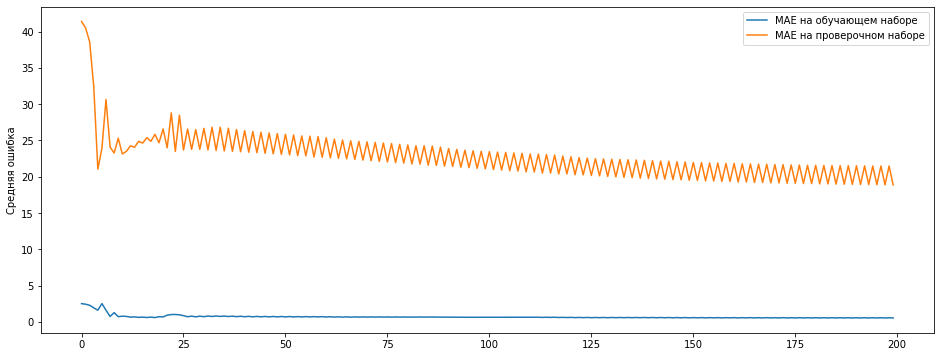

In [26]:
plt.plot(history.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [27]:
pred = model.predict(dataset_train).flatten()
pred_val = model.predict(dataset_val).flatten()

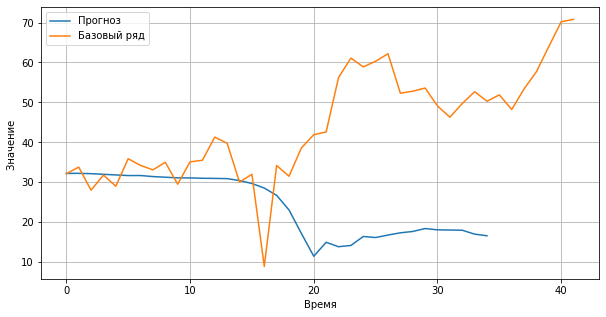

In [28]:
start = 0
step = 500
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [29]:
y_val[:]

array([32.10718113, 33.80358942, 28.00295341, 31.80376249, 29.0041021 ,
       35.89423007, 34.20327472, 33.10102668, 34.99823794, 29.50578931,
       35.10604518, 35.50719057, 41.3038349 , 39.75926756, 30.00648409,
       32.00125456,  8.90465289, 34.20035939, 31.49983076, 38.5950582 ,
       41.9049634 , 42.59939769, 56.20452399, 61.10638097, 58.89983274,
       60.3064993 , 62.19735871, 52.30485556, 52.80304633, 53.59041061,
       49.10358666, 46.29984225, 49.70476252, 52.68634606, 50.28758941,
       51.88642288, 48.21632732, 53.39600317, 57.70353305, 64.00742115,
       70.19708505, 70.80342672])

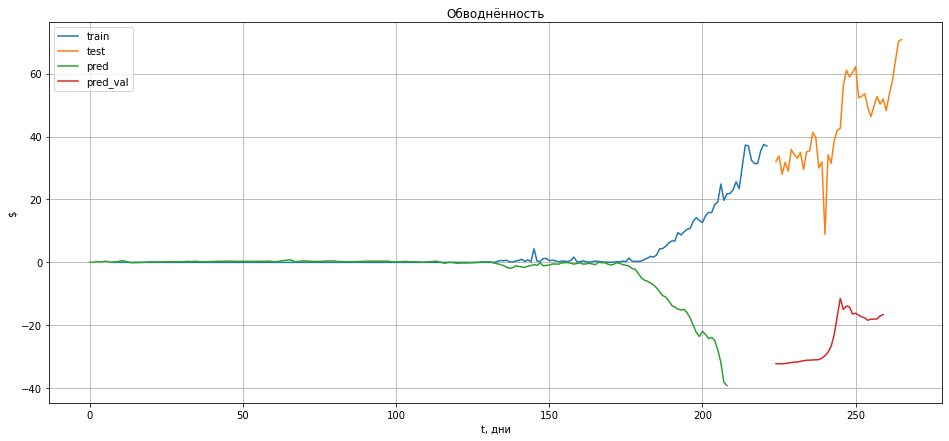

In [30]:
plt.figure(figsize=(16, 7))
plt.plot(data.index[x_len:y_train.shape[0]+x_len], y_train[:], label='train')
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:y_train.shape[0]+x_len+bias+future + len(y_val)],
         y_val[:], label='test')
plt.plot(pred[:] * (-1), label='pred')
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:y_train.shape[0]+x_len+bias+future + len(pred_val)],
         pred_val[:] * (-1), label='pred_val')
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
plt.title('Обводнённость')
plt.legend()
plt.show()